In [157]:
from torchvision.ops import masks_to_boxes
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from torchvision.ops import (
    masks_to_boxes,
    generalized_box_iou
)

In [4]:
df_path = r'/home/alex/Documents/new try/Data/Studie_daten/Dataframe.csv'
df = pd.read_csv(df_path, sep = ';')
train_indices, test_indices = train_test_split(df.index, test_size=0.3, random_state=42)
train_df = df.loc[train_indices].reset_index(drop = True)
test_df = df.loc[test_indices].reset_index(drop = True)

In [5]:
def load_checkpoint(model, filename):
    print('=> Loading checkpoint')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["state_dict"])

In [6]:
# HYPERPARAMETERS:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = False  # True if DEVICE == 'cuda' else False
LOGGING = False
BATCH_SIZE = 16
NUM_EPOCHS = 200
NUM_WORKERS = 0
IMAGE_SIZE = 256

random.seed(42)
torch.manual_seed(42)

In [7]:
resize_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)
TRAIN_TRANSFORM = A.Compose(
        [
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            #A.Rotate(limit=20, border_mode=cv2.BORDER_CONSTANT, value= 0,p=0.8),
            A.HorizontalFlip(p=0.5),
            ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
    )

TEST_TRANSFORM = A.Compose(
        [
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
    )

In [8]:
class Keypoint_dataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_path = self.df['new path'][idx]
        img = np.array(Image.open(img_path).convert('L'))
        keypoints = [(self.df['X_Th1_Original'][idx], self.df['Y_Th1_Original'][idx]),
                    (self.df['X_Th12_Original'][idx], self.df['Y_Th12_Original'][idx]),
                    (self.df['X_LeftRecess_Original'][idx], self.df['Y_LeftRecess_Original'][idx]),
                    (self.df['X_RightRecess_Original'][idx], self.df['Y_RightRecess_Original'][idx])] #T1_original, T12_original, LeftRecess_original, RightRecess_original
        if self.transform is not None:
            transformed = self.transform(image= img, keypoints=keypoints)
            img = transformed['image']
            keypoints = transformed['keypoints']
            keypoints = torch.from_numpy(np.float32(keypoints).flatten())

        return img.type(torch.float)/255, keypoints.unsqueeze(0)

In [9]:
train_keypoint_ds = Keypoint_dataset(train_df,
                        transform= TEST_TRANSFORM)
test_keypoint_ds = Keypoint_dataset(test_df,
                        transform= TEST_TRANSFORM)

In [10]:
class KeypointModel(nn.Module):
    def __init__(self):
        super(KeypointModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 8)  # 4 Keypoints with (x, y) coordinates => 4 * 2 = 8

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = KeypointModel()

In [16]:
train_loader = DataLoader(train_keypoint_ds,
                          batch_size= BATCH_SIZE,
                          num_workers= NUM_WORKERS,
                          pin_memory= PIN_MEMORY,
                          shuffle= True)

test_loader = DataLoader(test_keypoint_ds,
                          batch_size= 1,
                          num_workers= NUM_WORKERS,
                          pin_memory= PIN_MEMORY,
                          shuffle= False)

In [23]:
model = KeypointModel()

In [24]:
load_checkpoint(model, r'/home/alex/Documents/new try/Data/Studie_daten/fixpoint_detection_1_augmentation.pth.tar')
model.eval()

=> Loading checkpoint


KeypointModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
)

In [84]:
test_images, test_kps = next(iter(test_loader))
test_pred = model(test_images)
test_pred = test_pred[0].detach().numpy().astype(np.uint8)

In [85]:
test_pred

array([111,   3, 118, 212, 209, 193,  29, 185], dtype=uint8)

In [89]:
keypoint_image = torch.zeros(test_images.shape)
keypoint_image = keypoint_image[0,0]
for i in range(0,8,2):
    keypoint_image[test_pred[i+1],test_pred[i+1]] = 1

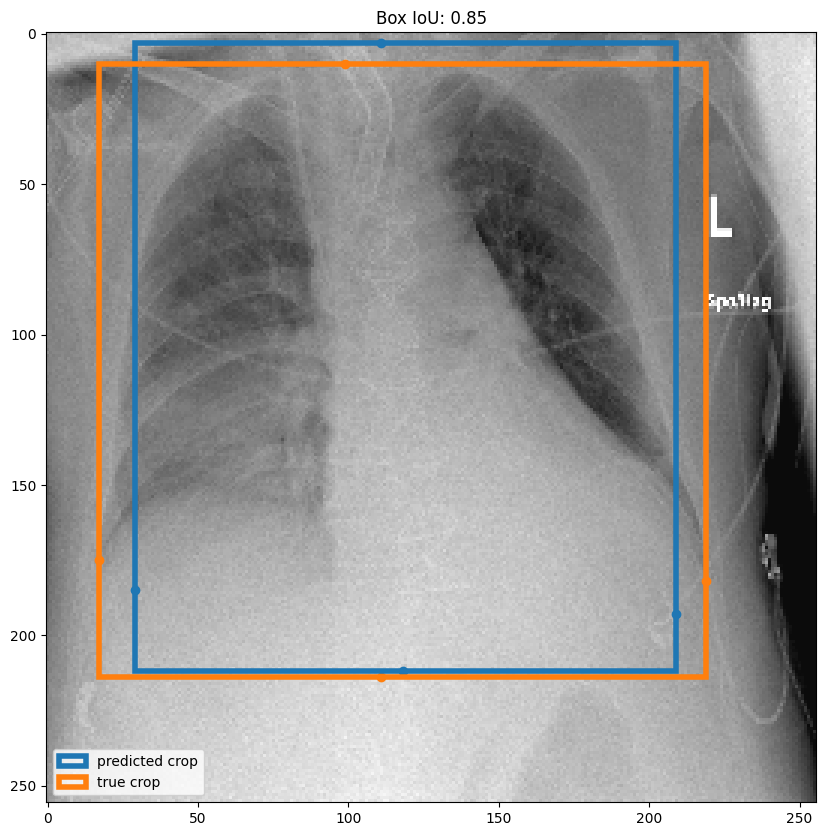

In [161]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.imshow(test_images[0,0], cmap ='gray', vmin = 0, vmax = 1)
pred_box = masks_to_boxes(keypoint_image.unsqueeze(0))[0]
boxes = []
test_kps = test_kps.to(torch.uint8)
for keypoints in [test_kps.detach().numpy().astype(np.uint8), test_pred]:
    keypoint_image = torch.zeros(test_images[0,0].shape)
    for i in range(0,8,2):
        keypoint_image[keypoints[i+1],keypoints[i]] = 1
    boxes.append(masks_to_boxes(keypoint_image.unsqueeze(0)))
test_box, pred_box = boxes[0][0], boxes[1][0]
for i in range(0,8,2):
    axs.scatter(test_pred[i],test_pred[i+1], color = 'C0')
    axs.scatter(test_kps[i],test_kps[i+1], color = 'C1')
rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0],
                                  pred_box[3] - pred_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='predicted crop')
rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                  test_box[3] - test_box[1], linewidth=4, edgecolor='C1', facecolor='none', label='true crop')

#pred_rect_copy = copy(rect_pred)
axs.add_patch(rect_pred)
axs.add_patch(rect_test)
box_iou = generalized_box_iou(boxes[0], boxes[1])
box_iou = torch.nan_to_num(box_iou, 0)
box_iou = torch.trace(box_iou)
plt.title(f'Box IoU: {box_iou:.2f}')
plt.legend()
plt.show()

In [174]:
test_image.shape, true_kp.shape, pred_kp.shape

(torch.Size([16, 1, 256, 256]), torch.Size([16, 8]), torch.Size([16, 8]))

In [190]:
test_image, true_kp = next(iter(train_loader))
true_kp = true_kp.squeeze(1)
pred_kp = model(test_images)
K = test_image.shape[0]
boxes = []
true_kp = true_kp.detach().numpy().astype(np.uint8)
pred_kp = pred_kp.detach().numpy().astype(np.uint8)
for keypoints in [true_kp, pred_kp]:
    keypoint_image = torch.zeros(test_image.shape)
    for k in range(K):
        for i in range(0,8,2):
            keypoint_image[k,0,keypoints[k,i+1],keypoints[k,i]] = 1
    boxes.append(masks_to_boxes(keypoint_image.squeeze(1)))
box_iou = generalized_box_iou(boxes[0], boxes[1])
box_iou = torch.nan_to_num(box_iou, 0)
box_iou = torch.trace(box_iou)
torch.round(box_iou/K, decimals = 2)

tensor(0.7100)

In [152]:
test_pred[0]

111

In [145]:
test_kps

tensor([ 99,  10, 111, 214, 219, 182,  17, 175], dtype=torch.uint8)

In [108]:
test_images[0,0].shape

torch.Size([256, 256])

In [134]:


def box_iou_keypoints(image_shape, kp_true, kp_pred):
    '''
    ímpage_shape [N,M]
    kp_true : [8]
    kp_pred : [8]
    '''
    boxes = []
    kp_true = kp_true.to(torch.uint8)
    for keypoints in [kp_true, kp_pred]:
        keypoint_image = torch.zeros(image_shape)
        for i in range(0,8,2):
            keypoint_image[keypoints[i],keypoints[i+1]] = 1
        boxes.append(masks_to_boxes(keypoint_image.unsqueeze(0)))


    box_iou = generalized_box_iou(boxes[0], boxes[1])
    box_iou = torch.nan_to_num(box_iou, 0)
    box_iou = torch.trace(box_iou)
    return box_iou

In [135]:
box_iou_keypoints(test_images[0,0].shape, test_kps[0,0], test_pred)

tensor([[0.5785]])